# Assignment 3: Classification of Image Data
November 24, 2022
- Meilin Lyu  
- Rohan Agarwal  
- Eric Chao  

In [ ]:
import numpy as np
import pandas as pd
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

import time
from typing import List
from tqdm import tqdm

##### Check for NaN (debugging purposes)


In [ ]:
DEBUGGING = []

def checkNan(desc, x):
    posinf = np.any(np.isposinf(x))
    neginf = np.any(np.isneginf(x))
    nan = np.any(np.isnan(x))
    if posinf or neginf or nan:
        print("NAN at:", len(DEBUGGING), desc, posinf, neginf, nan)
        DEBUGGING.append(x)

# Task 1. Acquire the Data

`Fashion-MNIST`: training set = 60,000 examples; test set = 10,000 examples. 

Each example is a 28x28 grayscale image (i.e. single channel), labeled out of 10 classes. 

Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms sharing the same image size and structure of training and testing splits.


----FINISHED DOWNLOAD
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


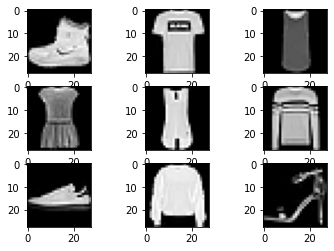

In [ ]:
from keras.datasets import fashion_mnist
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
# summarize loaded dataset
print("\n----FINISHED DOWNLOAD")
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

### Preprocessing

In [ ]:
trX = trainX.reshape((trainX.shape[0], trainX.shape[1]*trainX.shape[2],))
# Verify observations where correctly vectorized
a = trainX[0].flatten()
b = trX[0]
np.all(a == b)

True

In [ ]:
# Vectorize every record 28x28 to 784x1
fashion_trainX = trainX
fashion_testX = testX

trainX = trainX.reshape((trainX.shape[0], trainX.shape[1]*trainX.shape[2],))
testX = testX.reshape((testX.shape[0], testX.shape[1]*testX.shape[2],))

print("\n----FINISHED VECTORIZING DATASETS")
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
print('Normal Train: X=%s, y=%s' % (fashion_trainX.shape, trainy.shape))


----FINISHED VECTORIZING DATASETS
Train: X=(60000, 784), y=(60000,)
Test: X=(10000, 784), y=(10000,)
Normal Train: X=(60000, 28, 28), y=(60000,)


In [ ]:
# STANDARDIZED DATA
# Standardize the data: Zero-center and standard scaling per feature
from sklearn.preprocessing import StandardScaler
trainScaler = StandardScaler()
# Compute mean and std per feature
trainScaler.fit(trainX)

# Use the mean and standard deviations from Train data for Test data too
scaledTrainX = trainScaler.transform(trainX)
scaledTestX = trainScaler.transform(testX)

In [ ]:
# NORMALIZED DATA
# Normalize the data into (-1, 1) range
# normalize(x) <- x - min(X) / (max(X) - min(X)) = x / 255

normalTrainX = (2.*trainX/255) - 1
normalTestX = (2.*testX/255) - 1

# Task 2. MLP Implementation

Activation functions and Linear transformations are implemented as separate "layers", but they should be used as a single layer (e.g. one activation for every linear layer). 
In this case, ReLU only performs the rectification, and the input to output dimensions are equal.

### Layers

#### Abstract Layer Class

In [ ]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None

    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

#### Linear Layer

In [ ]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size, penalty=0, sig = 0.5):
        super().__init__()       # parent class' attributes
        self.ni = input_size     # number of input units
        self.no = output_size    # number of output units
        self.penalty = penalty
        self.sig = sig
        # Parameter initialization
        self.w = np.random.normal(loc=0, scale=self.sig, size=(output_size, input_size))
        self.b = np.zeros(output_size)

        # Housekeeping variables
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        '''
        x is a batch of N vectors, each of dimension ni
        '''
        self.cur_input = x

        # Add dimension to X, add dimension to W. This way, we vectorize
        # the matrix multiplication. The result is a vector with the results 
        # of each matrix mul of w with every input xi

        # Left is (1xNoxNi), Right is (NxNix1) -> N x No x 1
        # Inner @ is (N x No x 1), after squeeze: -> (N x No) + b
        Z = self.w[None, :, :] @ x[:, :, None]

        ans= (Z).squeeze() + self.b # careful when N=1
        return ans

    def backward(self, gradient):
        '''
        gradient is the array of partial derivatives from the l+1 layer.
        Computes gradient for this layer's parameters.
        '''
        assert self.cur_input is not None, "Must call forward before backward"
        # Update this layer's gradient
        dw = gradient[:, :, None] @ self.cur_input[:, None, :] + 2*self.penalty*self.w
        db = gradient
        self.gradient = [dw, db]
        # Compute gradient to pass down to next layer
        ans = gradient.dot(self.w)
        checkNan("back lin layer", ans)
        return ans

#### ReLU Layer

In [ ]:
# ReLU layer does not have any parameters to update.
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        # Compute the gradient in the forward pass
        # which is simply 1 for positive inputs, zero otherwise
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        # Chain rule
        g = gradient * self.gradient
        return g

#### Tanh Activation Layer

In [ ]:
# Tanh layer does not have any parameters to update.
class TanhLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        z = np.tanh(x)
        self.gradient = 1 - (z**2)
        return z

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        # Chain rule
        g = gradient * self.gradient
        return g

#### Leaky ReLU Layer

In [ ]:
class LeakyReLULayer(NeuralNetLayer):
    def __init__(self, c=0.01):
        super().__init__()
        self.c = c
        def slope(xi):
            if xi == 0:
                return xi
            elif xi < 0:
                return -self.c
            else:
                return 1
        self.slope = np.vectorize(slope)

    def forward(self, x):
        # ReLU, but multiply negative x by a constant 0 < c < 1
        leaky = np.maximum(0, x) + np.minimum(self.c * x, 0)
        self.gradient = self.slope(leaky)
        return leaky

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        # Chain rule
        g = gradient * self.gradient
        return g

#https://sefiks.com/2018/02/26/leaky-relu-as-an-neural-networks-activation-function/

#### Softmax (Output) Layer

In [ ]:
# SoftMax layer does not have any parameters to update.
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self, subtract_max=False):
        super().__init__()
        self.cur_probs = None
        self.subtract_max=subtract_max

    def forward(self, x):
        '''
        Compute class probabilities for every z score in x,
        each corresponding to one output unit (class). ?**
        '''
        checkNan("forward Linear Layer (X)", x)
        if np.any(x > 600):
            print("X might overflow")
            DEBUGGING.append(x)

        if self.subtract_max:
            z = np.max(x, axis=-1, keepdims=True)
            exps = np.exp(x-z)
        else:
            exps = np.exp(x)

        checkNan("forward Softmax exps", exps)
        denom = np.sum(exps, axis=-1)[:, None]
        probs = exps / denom
        checkNan("forward Softmax", denom)
        checkNan("forward Softmax Layer (probs)", probs)

        self.cur_probs = probs
        return probs

    def backward(self, target):
        '''
        target is the vector of correct labels for our outputs.
        Output layer is the first gradient wrt the
        Loss function (CE) that is computed in a backward pass.
        '''
        assert self.cur_probs is not None, "Must call forward before backward"
        # Computing gradient for composite CE(SoftMax(x), y) is 
        # easier than their individual gradients, is known to be y_hat - y
        return self.cur_probs - target

In [ ]:
class ScaleBeforeSoftmaxLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        '''
        Compute class probabilities for every z score in x,
        each corresponding to one output unit (class). ?**
        '''
        scaled = (x - np.max(x, axis=-1, keepdims=True)) / (np.max(x, axis=-1, keepdims=True) - np.min(x, axis=-1, keepdims=True))
        print(f"forward scale layer f{scaled.shape}", np.any(np.isposinf(scaled)),np.any(np.isneginf(scaled)),  np.any(np.isnan(scaled)))
        return scaled

    def backward(self, target):
        '''
        target is the vector of correct labels for our outputs.
        Output layer is the first gradient wrt the
        Loss function (CE) that is computed in a backward pass.
        '''
        assert target is not None, "Must call forward before backward"
        # Computing gradient for composite CE(SoftMax(x), y) is 
        # easier than their individual gradients, is known to be y_hat - y
        return target

## MLP class and Backpropagation

To compute a prediction for an input $x$ with the MLP (i.e. **forward pass**), we compute

$$
\hat{y} = \texttt{forward}_k(\texttt{forward}_{k-1}(\dots\texttt{forward}_1(x))\dots))
$$


Backpropagation is the core of a Neural Network's learning algorithm.
To perform backpropagation (i.e. **backward pass**), we call the method from the *last* layer of the MLP (the `SoftmaxOutputLayer`), $\texttt{backward}_L(\hat{y})$, 

The output of this call is then passed as the input to $\texttt{backward}_{N-1}$, and so on, until we get to the first layer of the network. 
In every call to `backward`, the respective layers are computing the Loss gradient with respect to their own parameters, and returning the chained gradient for the next layer to use.

**Recall**: The backpropagation algorithm *is not* in charge of updating the parameters -- this is the job of the optimization algorithm.

Gradient Descent for our MLP

In [ ]:
'''
Our MLP is able to compute gradients layer after layer, but we need 
to somehow use them to learn every layer's parameters.
For this we use an Optimizer class with two methods:
1) update: take a set of parameters and gradients,
    return the updated parameters
2) step: go through the layers of an MLP, applying update to every layer
'''

class Optimizer:
    def __init__(self, net):
        self.net = net
    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)
    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)

In [ ]:
from sklearn.utils import shuffle
from tqdm import tnrange, tqdm_notebook

class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):        # args is a variable-length list of Neural Net Layer instances
        # in order -- from input to hidden layers to output.
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            # print(f"shape input to ({layer.__class__.__name__}) = {x.shape}")
            x = layer.forward(x)
        return x

    def backward(self, target):
        # Update all parameter's gradients
        for layer in self.layers[::-1]:
            target = layer.backward(target)

    def fit(self, data_X, data_y, n_classes=None, steps=200, SGD=False, batch_size=500, lr=1e-2, showLoss=True, testX=None, testY=None):
        showAcc = testX is not None and testY is not None
        grad_descent = GradientDescentOptimizer(self, lr)
        N = data_X.shape[0]
        losses = []
        if n_classes is None:
            n_classes = np.max(data_y) + 1
        # One-hot encode y labels
        labels_y = data_y
        data_y = np.eye(n_classes)[np.array(data_y)] 
        tic = time.perf_counter()
        training = []
        testing = []

        if SGD:
            print("Stochastic Gradient Descent for", steps, "epochs")
            for _ in tnrange(steps, desc="Epochs"):
                # Random sample of bath_size indexes
                loss = None
                # Create mini batches and loop through each of them
                for batch_X, batch_y in batches(data_X, data_y, batch_size):
                    predictions = self.forward(batch_X)
                    # print("pred has nan", np.any(np.isnan(predictions)))
                    a = batch_y * np.log1p(predictions) # log1p to avoid log(0)
                    b = a.sum(axis=-1)
                    loss = -(b).mean()
                    self.backward(batch_y)  # Compute gradients for every layer
                    grad_descent.step()
                
                # Loss
                losses.append(loss)
                # Training Accuracy
                predictions = self.forward(data_X)
                pred_y = np.argmax(predictions, axis=-1) 
                training.append((pred_y == labels_y).mean())
                # Testing Accuracy
                if testX is not None and testY is not None:
                    predictions = self.forward(testX)
                    pred_y = np.argmax(predictions, axis=-1)
                    testing.append((pred_y == testY).mean())
        else:
            print("Full Batch Gradient Descent for", steps, "steps")
            # Full pass over the data at every step
            for i in tqdm(range(steps)):
                predictions = self.forward(data_X)
                a = data_y * np.log1p(predictions) # log1p to avoid log(0)
                b = a.sum(axis=-1)
                loss = -b.mean()
                losses.append(loss)
                self.backward(data_y)  # Compute gradients for every layer
                grad_descent.step()
        toc = time.perf_counter()
        print(f"[Trained in {toc - tic:0.4f} seconds]") 
        
        if showAcc:
            print("Printing accuracy over epochs...")
            x_data = range(1, steps+1)
            plt.plot(x_data, training, label = "Training")
            if len(testing):
                plt.plot(x_data, testing, label = "Testing")
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.title("Training/Testing Accuracy")
            plt.legend()
            plt.show()
        elif showLoss:
            plt.plot(losses)
            plt.xlabel("Epoch")
            plt.ylabel("Cross-entropy Loss")

        return losses, training, testing or None


# Task 3. Running Experiments

### Utilities

#### Plot and Save figure

In [ ]:
def plot_mlp(title, fname, loss=None, training=None, testing=None):
    showAcc = training is not None and testing is not None
    if showAcc:
        print("Plotting accuracy over epochs...")
        steps = len(training)
        x_data = range(steps)
        plt.plot(x_data, training, label = "Training")
        if len(testing):
            plt.plot(x_data, testing, label = "Testing")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        print("save to", fname)
        plt.title(title)
        plt.legend()
        plt.savefig(fname,dpi=300)
        plt.show()
    elif loss is not None:
        print("Plotting loss over epochs...")
        plt.plot(loss)
        plt.xlabel("Epoch")
        plt.ylabel("Cross-entropy Loss")
        print("save to", fname)
        plt.title(title)
        plt.legend()
        plt.savefig(fname,dpi=300)
        plt.show()

#### Evaluate Accuracy

In [ ]:
def evaluate_acc(pred_labels, true_labels):
    '''Expects two numpy arrays'''
    return (pred_labels == true_labels).mean()

#### Generate mini batches size k

In [ ]:
def batches(data, labels, k):
    # To use in a for loop, does not shuffle in place
    assert len(data) == len(labels)
    indices = np.random.permutation(len(data))
    for i in range(0, len(data), k):
        yield data[indices[i:i+k]], labels[indices[i:i+k]]

#### Training loop

In [ ]:
from sklearn.utils import shuffle
from tqdm import tnrange, tqdm_notebook

def train(mlp: MLP, grad_descent: Optimizer, data_X, data_y, n_classes=None, steps=200, SGD=False, batch_size=500):
    N = data_X.shape[0]
    losses = []
    if n_classes is None:
        n_classes = np.max(data_y) + 1
    # One-hot encode y labels
    data_y = np.eye(n_classes)[np.array(data_y)] 
    tic = time.perf_counter()
    if SGD:
        print("Stochastic Gradient Descent for", steps, "epochs")
        for _ in tnrange(steps, desc="Epochs"):
            # Random sample of bath_size indexes
            loss = None
            # Create mini batches and loop through each of them
            for batch_X, batch_y in batches(data_X, data_y, batch_size):
                predictions = mlp.forward(batch_X)
                a = batch_y * np.log1p(predictions) # log1p to avoid log(0)
                loss = -(a.sum(axis=-1)).mean()
                mlp.backward(batch_y)  # Compute gradients for every layer
                grad_descent.step()
            losses.append(loss)
    else:
        print("Full Batch Gradient Descent")
        # Full pass over the data at every step
        for i in tqdm(range(steps)):
            predictions = mlp.forward(data_X)
            a = data_y * np.log1p(predictions) # log1p to avoid log(0)
            b = a.sum(axis=-1)
            loss = -b.mean()
            losses.append(loss)
            mlp.backward(data_y)  # Compute gradients for every layer
            grad_descent.step()
    toc = time.perf_counter()
    print(f"[Trained Logistic Regression in {toc - tic:0.4f} seconds]")    
    
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross-entropy Loss")
    return losses

# NOTE: we could make this a method of an MLP which receives an optimizer class

## Experiment 1. MLPs with 0, 1 and 2 hidden layers

### MLP with no hidden layer


Summary results: <br/>  
0-layer MLP  <br/>
200 epochs, 0.01 learning rate <br/>
Peak training accuracy: **81.56 %** <br/> 
Peak test accuracy: **79.56 %**

#### Loss plot over Epochs

Stochastic Gradient Descent for 20 epochs


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

[Trained in 114.6397 seconds]


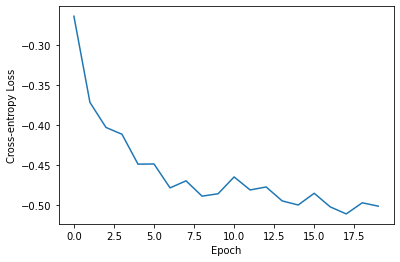

In [ ]:
INPUT_UNITS = normalTrainX.shape[-1]
EPOCHS = 20
N_CLASSES = 10

mlp0 = MLP(
    LinearLayer(INPUT_UNITS, N_CLASSES),
    SoftmaxOutputLayer(subtract_max=True)
)

hist_0 = mlp0.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, batch_size=500, lr=1e-2)

In [ ]:
predictions = mlp0.forward(normalTestX)
# encode class probabilities into predicted class id
pred_y = np.argmax(predictions, axis=-1) 
# Testing Accuracy
(pred_y == testy).mean()

0.7171

#### Accuracy plot over Epochs

Stochastic Gradient Descent for 200 epochs


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

[Trained in 784.4576 seconds]
Printing accuracy over epochs...


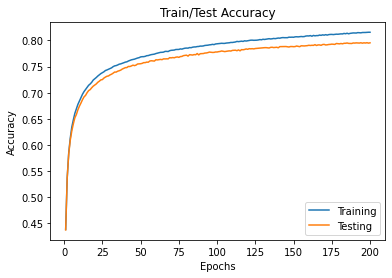

In [ ]:
INPUT_UNITS = normalTrainX.shape[-1]
EPOCHS = 200
N_CLASSES = 10

mlp0 = MLP(
    LinearLayer(INPUT_UNITS, N_CLASSES),
    SoftmaxOutputLayer(subtract_max=True)
)

# Pass a test set to plot training vs testing accuracies 
hist_0 = mlp0.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, lr=.01, testX=normalTestX, testY=testy)

In [ ]:
losses, training, testing = hist_0
l=0;e=EPOCHS;lr=0.01
print(f"=>{l}-layer MLP, {e} epochs, {lr} learning rate")
print(f"Peak training accuracy:","{:.2f}".format(np.max(training)*100),"%")
print(f"Peak test accuracy:", "{:.2f}".format(np.max(testing)*100),"%")

=>0-layer MLP, 200 epochs, 0.01 learning rate
Peak training accuracy: 81.56 %
Peak test accuracy: 79.56 %


### 1-hidden layer MLP


Summary Results: <br/>
1-layer MLP, 100 epochs, 0.01 learning rate <br/> 
Peak training accuracy: **82.96 %** <br/> 
Peak test accuracy: **81.06 %**

#### Loss plot over Epochs

Stochastic Gradient Descent for 20 epochs


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

[Trained in 621.3426 seconds]


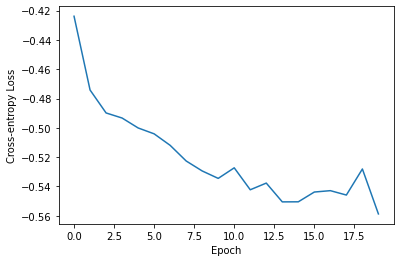

In [ ]:
INPUT_UNITS = normalTrainX.shape[-1]
EPOCHS = 20
N_CLASSES = 10
HIDDEN_LAYER_UNITS = 128

mlp1 = MLP(
    LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES),
    SoftmaxOutputLayer(subtract_max=True)
)

hist_2 = mlp1.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, lr=1e-2)

In [ ]:
# Feedb test set to the network
predictions = mlp1.forward(normalTestX)
# encode class probabilities into predicted class id
pred_y = np.argmax(predictions, axis=-1)

# Testing Accuracy
(pred_y == testy).mean()

0.7707

#### Accuracy plot over Epochs

Stochastic Gradient Descent for 100 epochs


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

[Trained in 3249.8602 seconds]
Printing accuracy over epochs...


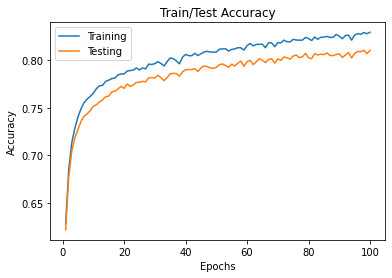

In [ ]:
INPUT_UNITS = normalTrainX.shape[-1]
EPOCHS = 100
N_CLASSES = 10
HIDDEN_LAYER_UNITS = 128

mlp1 = MLP(
     LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES),
    SoftmaxOutputLayer(subtract_max=True)
) 

# Pass a test set to plot training vs testing accuracies
hist_1 = mlp1.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, lr=.01, testX=normalTestX, testY=testy)

In [ ]:
losses, training, testing = hist_1 
l=1;e=100;lr=0.01
print(f"=>{l}-layer MLP, {e} epochs, {lr} learning rate")
print(f"Peak training accuracy:","{:.2f}".format(np.max(training)*100),"%")
print(f"Peak test accuracy:", "{:.2f}".format(np.max(testing)*100),"%")

=>1-layer MLP, 100 epochs, 0.01 learning rate
Peak training accuracy: 82.96 %
Peak test accuracy: 81.06 %


In [ ]:
# Feedb test set to the network
predictions = mlp1.forward(normalTestX)
# encode class probabilities into predicted class id
pred_y = np.argmax(predictions, axis=-1) 

# Testing Accuracy
(pred_y == testy).mean()

0.8105

### 2-hidden layer MLP

Summary results: <br/>2-layer MLP, 90 epochs, 0.01 and 0.001 learning rate <br/> 
Peak training accuracy: ** %** <br/> 
Peak test accuracy: ** %**


#### Loss plot over epochs

Stochastic Gradient Descent for 20 epochs


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

X might overflow
[Trained in 1251.8552 seconds]


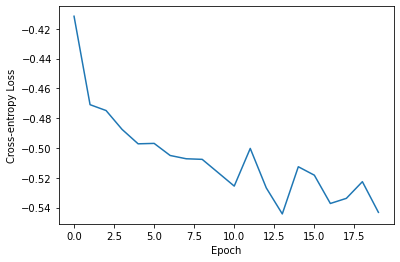

In [ ]:
INPUT_UNITS = normalTrainX.shape[-1]
EPOCHS = 20
N_CLASSES = 10
HIDDEN_LAYER_UNITS = 128

mlp2_ = MLP(
    LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, HIDDEN_LAYER_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES),
    SoftmaxOutputLayer()
)

hist_3 = mlp2_.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, batch_size=500, lr=1e-3)

##### Test Accuracy

In [ ]:
# Feedb test set to the network
predictions = mlp2_.forward(normalTestX)
# encode class probabilities into predicted class id
pred_y = np.argmax(predictions, axis=-1) 

# Testing Accuracy
(pred_y == testy).mean()

0.7441

#### Accuracy plot over Epochs (lr=1e-2)

In [ ]:
# retry here with 90
INPUT_UNITS = normalTrainX.shape[-1]
EPOCHS = 90
N_CLASSES = 10
HIDDEN_LAYER_UNITS = 128
LR = 1e-2

mlp2 = MLP(
    LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, HIDDEN_LAYER_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES),
    SoftmaxOutputLayer(subtract_max=True)
)

hist_2 = mlp2.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, lr=LR, testX=normalTestX, testY=testy)

Stochastic Gradient Descent for 90 epochs


Epochs:   0%|          | 0/90 [00:00<?, ?it/s]

In [ ]:
losses, training, testing = hist_2 
l=2;e=EPOCHS;lr=LR
print(f"=>{l}-layer MLP, {e} epochs, {lr} learning rate")
print(f"Peak training accuracy:","{:.2f}".format(np.max(training)*100),"%")
print(f"Peak test accuracy:", "{:.2f}".format(np.max(testing)*100),"%")

In [ ]:
plot_mlp("2 Layer MLP, lr=1e-2", "2-layer-mlp-901e-2",loss=None, training=training, testing=testing)

In [ ]:
plot_mlp("2 Layer MLP, Loss", "2-layerl-mlp-901e-2-loss", loss=losses)

#### Accuracy plot over Epochs (lr=1e-3)

Stochastic Gradient Descent for 90 epochs


Epochs:   0%|          | 0/90 [00:00<?, ?it/s]

[Trained in 4773.2987 seconds]
Printing accuracy over epochs...


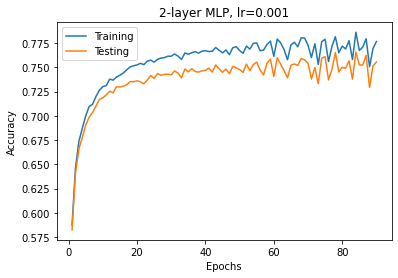

In [ ]:
# retry here with 90
INPUT_UNITS = normalTrainX.shape[-1]
EPOCHS = 90
N_CLASSES = 10
HIDDEN_LAYER_UNITS = 128

mlp2 = MLP(
    LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, HIDDEN_LAYER_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES),
    SoftmaxOutputLayer(subtract_max=True)
)

hist_2 = mlp2.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, lr=1e-3, testX=normalTestX, testY=testy)

In [ ]:
losses, training, testing = hist_2 
l=2;e=EPOCHS;lr=1e-3
print(f"=>{l}-layer MLP, {e} epochs, {lr} learning rate")
print(f"Peak training accuracy:","{:.2f}".format(np.max(training)*100),"%")
print(f"Peak test accuracy:", "{:.2f}".format(np.max(testing)*100),"%")

=>2-layer MLP, 90 epochs, 0.001 learning rate
Peak training accuracy: 78.61 %
Peak test accuracy: 76.57 %


Plotting accuracy over epochs...
save to 2-layer-mlp-901e3


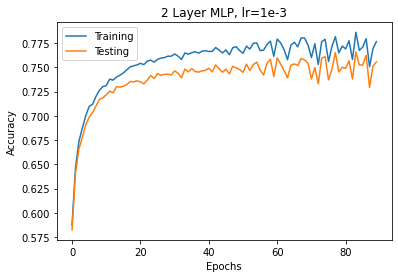

In [ ]:
plot_mlp("2 Layer MLP, lr=1e-3", "2-layer-mlp-901e3",loss=None, training=training, testing=testing)

Plotting loss over epochs...
save to 2-layerl-mlp-901e3-loss


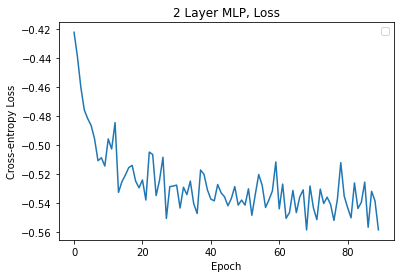

In [ ]:
plot_mlp("2 Layer MLP, Loss", "2-layerl-mlp-901e3-loss", loss=losses)

#### Comparison of Peak Accuracy


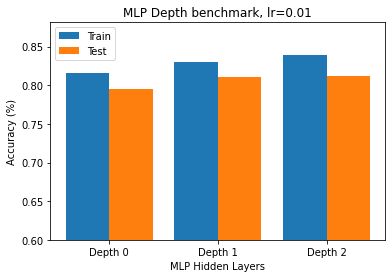

In [ ]:
# Cached Values for convenience (training runs are long)
X = ['Depth 0','Depth 1','Depth 2']
training_acc = [0.8156, 0.8296, .8394]
testing_acc = [0.7956, 0.8106, .8123]
  
X_axis = np.arange(len(X))

a = 0.4
plt.bar(X_axis - 0.2, training_acc, 0.4, label = 'Train')
plt.bar(X_axis + 0.2, testing_acc, 0.4, label = 'Test')
  
plt.xticks(X_axis, X)
plt.ylim(bottom=0.6)
plt.xlabel("MLP Hidden Layers")
plt.ylabel("Accuracy (%)")
plt.title(f"MLP Depth benchmark, lr=0.01")
plt.legend()
plt.savefig("mlp_depth_benchmark",dpi=300)
plt.show()

## Experiment 2. Using TanH and Leaky ReLU activations
We ran 2-layer MLPs with three different activation functions and afixed number of **40 epochs** and **128 hidden units**.
<br/>
Summary Results:
- Ordinary ReLU proved to have the best performance of the three, closely followed by Leaky ReLU, and lastly TanH.

Note that a possible explanation to the lower performance of TanH activation is that it is a saturating activation function (it squashes all inputs in a fixed range -1 to 1). This restricts the capacity of the neural network to update its weights. Once a neuron saturates (is always 1), then subsequent neurons relying on this neuron might heavily depend on this 1, making very confident but potentially incorrect predictions on unseen data. It is known that saturating activation functions have poorer generalization performance because of this.

In [ ]:
# For all 3 networks
INPUT_UNITS = normalTrainX.shape[-1]
EPOCHS = 40
N_CLASSES = 10
HIDDEN_LAYER_UNITS = 128
LEARN_RATE = 1e-2

#### ReLU activation

Stochastic Gradient Descent for 40 epochs


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

[Trained in 2434.6090 seconds]
Printing accuracy over epochs...


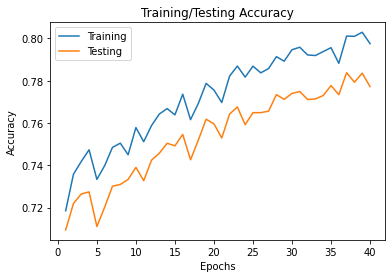

In [ ]:
mlp_relu = MLP(
    LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, HIDDEN_LAYER_UNITS),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES),
    SoftmaxOutputLayer(subtract_max=True)
)

reluData = mlp_relu.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, batch_size=500, lr=LEARN_RATE, testX=normalTestX, testY=testy)

#### TanH activation

Stochastic Gradient Descent for 40 epochs


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

[Trained in 2408.4432 seconds]
Printing accuracy over epochs...


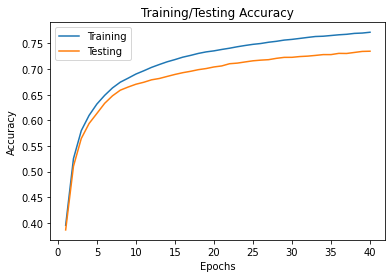

In [ ]:
mlp_tanh = MLP(
    LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS),
    TanhLayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, HIDDEN_LAYER_UNITS),
    TanhLayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES),
    SoftmaxOutputLayer(subtract_max=True)
)

tanhData = mlp_tanh.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, batch_size=500, lr=LEARN_RATE, testX=normalTestX, testY=testy)

#### Leaky ReLU activation

Stochastic Gradient Descent for 40 epochs


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

X might overflow
[Trained in 2826.5920 seconds]
Printing accuracy over epochs...


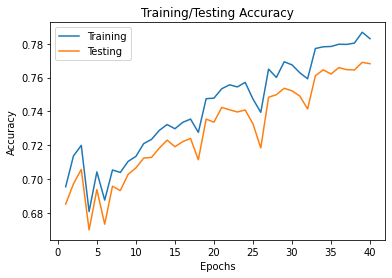

In [ ]:
mlp_leaky = MLP(
    LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, HIDDEN_LAYER_UNITS),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES),
    SoftmaxOutputLayer(subtract_max=True)
)

leakyReluData = mlp_leaky.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, batch_size=500, lr=LEARN_RATE, testX=normalTestX, testY=testy)

#### Accuracy per activation function
Results are obtained when training for a fixed number of epochs:


In [ ]:
l_relu, train_relu, test_relu = reluData
l_tanh, train_tanh, test_tanh = tanhData
l_leaky, train_leaky, test_leaky = leakyReluData

relu_acc_train = np.max(train_relu)
relu_acc_test = np.max(test_relu)
tanh_acc_train = np.max(train_tanh)
tanh_acc_test = np.max(test_tanh)
leaky_acc_train = np.max(train_leaky)
leaky_acc_test = np.max(test_leaky)
print(f"WITH {EPOCHS} EPOCHS")
print("RELU")
print(f"Peak training accuracy:","{:.2f}".format(relu_acc_train*100),"%")
print(f"Peak test accuracy:", "{:.2f}".format(relu_acc_test*100),"%")
print("TANH")
print(f"Peak training accuracy:","{:.2f}".format(tanh_acc_train*100),"%")
print(f"Peak test accuracy:", "{:.2f}".format(tanh_acc_test*100),"%")
print("LEAKY RELU")
print(f"Peak training accuracy:","{:.2f}".format(leaky_acc_train*100),"%")
print(f"Peak test accuracy:", "{:.2f}".format(leaky_acc_test*100),"%")

WITH 40 EPOCHS
RELU
Peak training accuracy: 80.30 %
Peak test accuracy: 78.38 %
TANH
Peak training accuracy: 77.19 %
Peak test accuracy: 73.49 %
LEAKY RELU
Peak training accuracy: 78.68 %
Peak test accuracy: 76.90 %


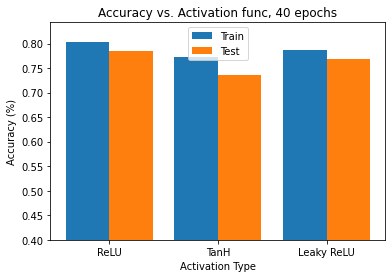

In [ ]:
## Plotting a bar graph for the above values  
X = ['ReLU','TanH','Leaky ReLU']
training_acc = [relu_acc_train, tanh_acc_train, leaky_acc_train]
testing_acc = [relu_acc_test, tanh_acc_test, leaky_acc_test]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, training_acc, 0.4, label = 'Train')
plt.bar(X_axis + 0.2, testing_acc, 0.4, label = 'Test')
  
plt.xticks(X_axis, X)
plt.ylim(bottom=0.4)
plt.xlabel("Activation Type")
plt.ylabel("Accuracy (%)")
plt.title(f"Accuracy vs. Activation func, {EPOCHS} epochs")
plt.legend()
plt.savefig("activations_acc_benchmark",dpi=300)
plt.show()


#### Save Accuracy and Loss Plots for Experiment 2

Plotting accuracy over epochs...
save to 2-mlp-relu-acc


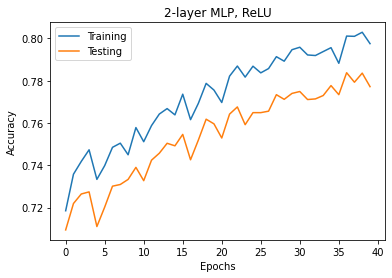

In [ ]:
plot_mlp("2-layer MLP, ReLU", "2-mlp-relu-acc", training=train_relu, testing=test_relu)


Plotting loss over epochs...
save to 2-mlp-relu-loss


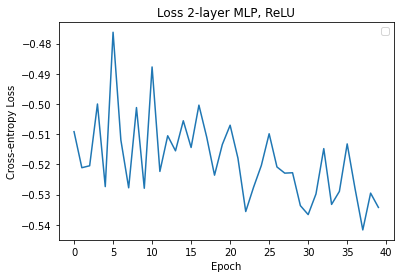

In [ ]:
plot_mlp("Loss 2-layer MLP, ReLU", "2-mlp-relu-loss", loss=l_relu)

Plotting accuracy over epochs...
save to 2-mlp-tanh-acc


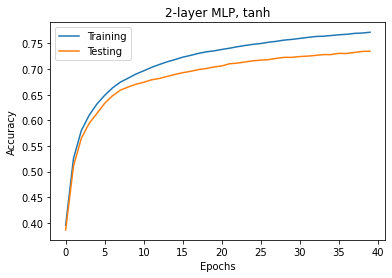

In [ ]:
plot_mlp("2-layer MLP, tanh", "2-mlp-tanh-acc", training=train_tanh, testing=test_tanh)


Plotting loss over epochs...
save to 2-mlp-tanh-loss


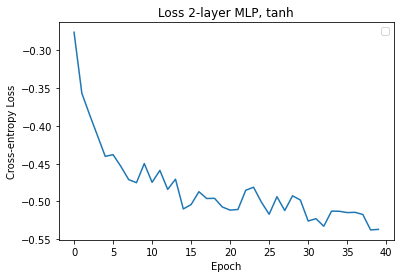

In [ ]:
plot_mlp("Loss 2-layer MLP, tanh", "2-mlp-tanh-loss", loss=l_tanh)

Plotting accuracy over epochs...
save to 2-mlp-leaky-acc


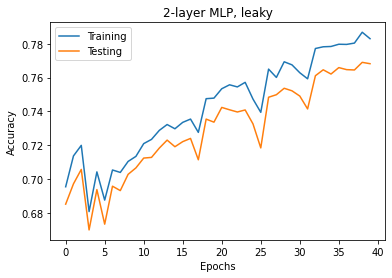

In [ ]:
plot_mlp("2-layer MLP, leaky", "2-mlp-leaky-acc", training=train_leaky, testing=test_leaky)


Plotting loss over epochs...
save to 2-mlp-leaky-loss


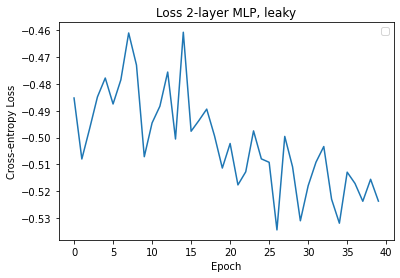

In [ ]:
plot_mlp("Loss 2-layer MLP, leaky", "2-mlp-leaky-loss", loss=l_leaky)

## Experiment 3. Using L2 Regularization on Network Weights

In [ ]:
INPUT_UNITS = normalTrainX.shape[-1]
EPOCHS = 20
N_CLASSES = 10
HIDDEN_LAYER_UNITS = 128

lambda = 0.3


Stochastic Gradient Descent for 5 epochs


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

[Trained in 274.9337 seconds]
Printing accuracy over epochs...


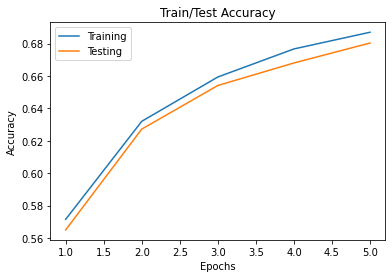

In [ ]:
mlp_l2 = MLP(
    LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS, penalty=0.3),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, HIDDEN_LAYER_UNITS, penalty=0.3),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES, penalty=0.3),
    SoftmaxOutputLayer()
)

hist_l2 = mlpl2_.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, batch_size=500, lr=0.001, testX=normalTestX, testY=testy)

lambda = 0.1


Stochastic Gradient Descent for 5 epochs


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

[Trained in 249.7072 seconds]
Printing accuracy over epochs...


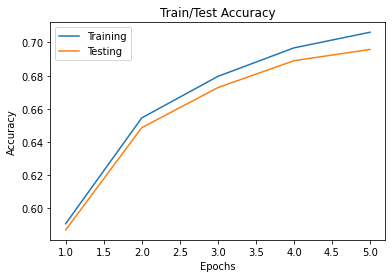

In [ ]:
mlpl2_1 = MLP(
    LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS, penalty=0.1),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, HIDDEN_LAYER_UNITS, penalty=0.1),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES, penalty=0.1),
    SoftmaxOutputLayer()
)

histl2_1 = mlpl2_1.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, batch_size=500, lr=0.001, testX=normalTestX, testY=testy)

lambda = 0.05

Stochastic Gradient Descent for 5 epochs


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

[Trained in 285.9641 seconds]
Printing accuracy over epochs...


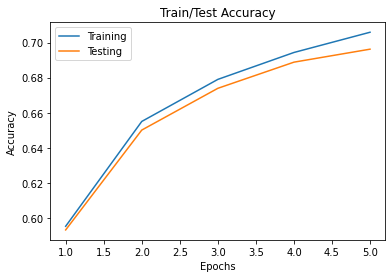

In [ ]:
mlpl2_2 = MLP(
    LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS, penalty=0.05),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, HIDDEN_LAYER_UNITS, penalty=0.05),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES, penalty=0.05),
    SoftmaxOutputLayer()
)

histl2_2 = mlpl2_2.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=5, SGD=True, batch_size=500, lr=0.001, testX=normalTestX, testY=testy)

* lambda = 0.05
* lr = 0.001
* epochs = 90


Stochastic Gradient Descent for 90 epochs


Epochs:   0%|          | 0/90 [00:00<?, ?it/s]

[Trained in 4284.7242 seconds]
Printing accuracy over epochs...


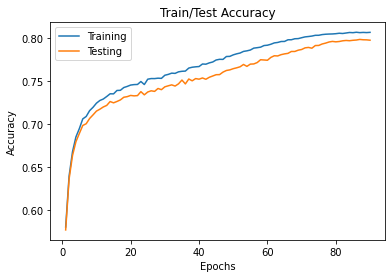

In [ ]:
mlpl2_3 = MLP(
    LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS, penalty=0.05),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, HIDDEN_LAYER_UNITS, penalty=0.05),
    ReLULayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES, penalty=0.05),
    SoftmaxOutputLayer()
)

histl2_3 = mlpl2_3.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, batch_size=500, lr=0.001, testX=normalTestX, testY=testy)

In [ ]:
predictions = mlpl2_3.forward(normalTestX)
# encode class probabilities into predicted class id
pred_y = np.argmax(predictions, axis=-1) 

# Testing Accuracy
(pred_y == testy).mean()

0.7974

## Experiment 4. Using Un-normalized Images 

In [ ]:
INPUT_UNITS = trainX.shape[-1]
EPOCHS = 20
N_CLASSES = 10
HIDDEN_LAYER_UNITS = 128

Stochastic Gradient Descent for 20 epochs


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

[Trained in 983.8807 seconds]
Printing accuracy over epochs...


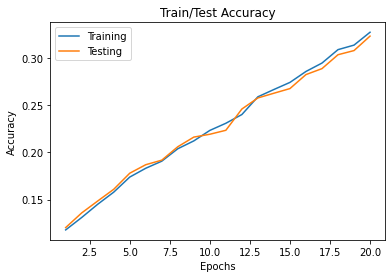

In [ ]:
mlp6_ = MLP(
    LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS, sig = np.sqrt(2/28*28)),
    TanhLayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, HIDDEN_LAYER_UNITS, sig = np.sqrt(2/28*28)),
    TanhLayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES, sig = np.sqrt(2/28*28)),
    SoftmaxOutputLayer(subtract_max = True)
)

hist_6 = mlp6_.fit(trainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, batch_size=500, lr=0.001, testX=testX, testY=testy )

compare to using normalized data with the same settings:

In [ ]:
INPUT_UNITS = normalTrainX.shape[-1]
EPOCHS = 20
N_CLASSES = 10
HIDDEN_LAYER_UNITS = 128

Stochastic Gradient Descent for 20 epochs


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

[Trained in 991.3677 seconds]
Printing accuracy over epochs...


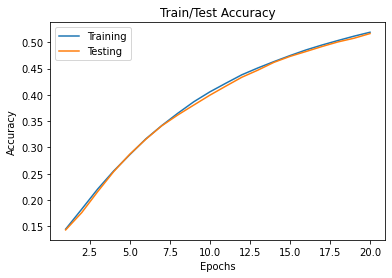

In [ ]:
mlp6_1 = MLP(
    LinearLayer(INPUT_UNITS, HIDDEN_LAYER_UNITS),
    TanhLayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, HIDDEN_LAYER_UNITS),
    TanhLayer(),
    LinearLayer(HIDDEN_LAYER_UNITS, N_CLASSES),
    SoftmaxOutputLayer(subtract_max = True)
)

hist_6_1 = mlp6_1.fit(normalTrainX, trainy, n_classes=N_CLASSES, steps=EPOCHS, SGD=True, batch_size=500, lr=0.001, testX=normalTestX, testY=testy )

## Experiment 5. ConvNet using Keras & Tensorflow

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

N_CLASSES = 10

img_height = 28
img_width = 28

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(32, 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(N_CLASSES)
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0

In [ ]:
# Add testing set as validation set to check for overfitting

epochs=8
history = model.fit(
  x=fashion_trainX,
  y=trainy,
  epochs=epochs,
  validation_split=0.15
)

Epoch 1/8
1594/1594 [==============================] - 51s 31ms/step - loss: 0.4420 - accuracy: 0.8412 - val_loss: 0.3427 - val_accuracy: 0.8771
Epoch 2/8
1594/1594 [==============================] - 48s 30ms/step - loss: 0.2950 - accuracy: 0.8932 - val_loss: 0.2924 - val_accuracy: 0.8939
Epoch 3/8
1594/1594 [==============================] - 49s 31ms/step - loss: 0.2457 - accuracy: 0.9096 - val_loss: 0.2530 - val_accuracy: 0.9089
Epoch 4/8
1594/1594 [==============================] - 48s 30ms/step - loss: 0.2173 - accuracy: 0.9200 - val_loss: 0.2541 - val_accuracy: 0.9086
Epoch 5/8
1594/1594 [==============================] - 48s 30ms/step - loss: 0.1928 - accuracy: 0.9294 - val_loss: 0.2394 - val_accuracy: 0.9134
Epoch 6/8
1594/1594 [==============================] - 49s 31ms/step - loss: 0.1711 - accuracy: 0.9359 - val_loss: 0.2415 - val_accuracy: 0.9159
Epoch 7/8
1594/1594 [==============================] - 50s 31ms/step - loss: 0.1519 - accuracy: 0.9440 - val_loss: 0.2297 - val_ac

In [ ]:
# testing accuracy
loss, acc = model.evaluate(fashion_testX, testy, verbose=2)
print("CNN model, accuracy: {:5.2f}%".format(100 * acc))

# 313/313 - 4s - loss: 0.2449 - accuracy: 0.9166 - 4s/epoch - 11ms/step
# CNN model, accuracy: 91.66%

313/313 - 4s - loss: 0.2449 - accuracy: 0.9166 - 4s/epoch - 11ms/step
CNN model, accuracy: 91.66%


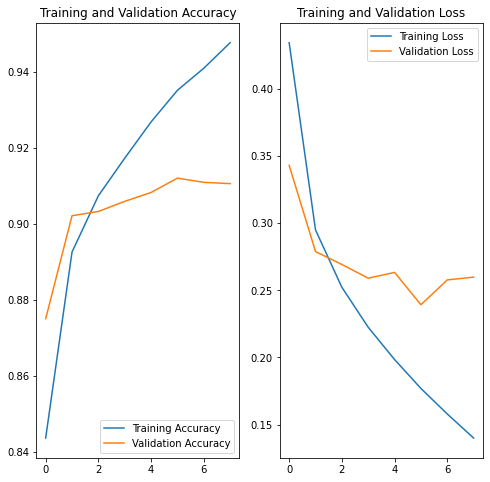

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### CNN Grid Search for Hyperparamter Tuning

Don't run unless you have to since it takes a long time

In [ ]:
def create_model(filters_1, filters_2, filters_1_size, filters_2_size):
  model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
    layers.Conv2D(filters_1, filters_1_size, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters_2, filters_2_size, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(N_CLASSES)
  ])

  model.compile(
      optimizer='adam',
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
      )
  
  return model

my_classifier = KerasClassifier(create_model)

grid = {'epochs': [6],'filters_1': [8, 16, 32],'filters_2': [16, 32],'filters_1_size': [2, 3],'filters_2_size': [2, 3]}

validator = GridSearchCV(my_classifier, param_grid=grid, n_jobs=-1, verbose=1, cv=2)
validator.fit(fashion_trainX, trainy)

print('The parameters of the best model are: ')
print(validator.best_params_)

# validator.best_estimator_ returns sklearn-wrapped version of best model.
# validator.best_estimator_.model returns the (unwrapped) keras model
best_model = validator.best_estimator_.model
metric_names = best_model.metrics_names
metric_values = best_model.evaluate(fashion_testX, testy)
for metric, value in zip(metric_names, metric_values):
    print(metric, ': ', value)

# The parameters of the best model are: 
# {'epochs': 6, 'filters_1': 32, 'filters_1_size': 2, 'filters_2': 32, 'filters_2_size': 3}
# 313/313 [==============================] - 3s 10ms/step - loss: 0.2597 - accuracy: 0.9098
# loss :  0.2597171366214752
# accuracy :  0.9097999930381775

# previously, 32 3 16 2 after 10 epochs returned 93%
# now, hopefully it'll be better? 
# with new 32 2 32 3 after 8 epochs returns 95.35%

Fitting 2 folds for each of 24 candidates, totalling 48 fits
Epoch 1/6
1875/1875 [==============================] - 63s 33ms/step - loss: 0.4271 - accuracy: 0.8465
Epoch 2/6
1875/1875 [==============================] - 62s 33ms/step - loss: 0.2843 - accuracy: 0.8972
Epoch 3/6
1875/1875 [==============================] - 61s 33ms/step - loss: 0.2420 - accuracy: 0.9102
Epoch 4/6
1875/1875 [==============================] - 62s 33ms/step - loss: 0.2100 - accuracy: 0.9222
Epoch 5/6
1875/1875 [==============================] - 63s 33ms/step - loss: 0.1883 - accuracy: 0.9296
Epoch 6/6
1875/1875 [==============================] - 62s 33ms/step - loss: 0.1677 - accuracy: 0.9382
The parameters of the best model are: 
{'epochs': 6, 'filters_1': 32, 'filters_1_size': 2, 'filters_2': 32, 'filters_2_size': 3}
313/313 [==============================] - 3s 10ms/step - loss: 0.2597 - accuracy: 0.9098
loss :  0.2597171366214752
accuracy :  0.9097999930381775


## Experiment 6. Best Performance Possible

Grid search for finding the best implementation of the MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

grid = {"hidden_layer_sizes": [
    (256,),
    (128, ),
    (64, ),
    (32, 32),
    (64, 32),
    (64, 64), 
    (128, 64),
    (128, 128),
    (32, 32, 32),
    (64, 64, 64)
    ], "alpha": [0.0001, 0.001, 0.01],
    "solver": ["sgd"],
    "activation": ["relu"]
    }

clf = MLPClassifier(random_state=1, max_iter=50, batch_size=500, early_stopping=True)
validator = GridSearchCV(clf, param_grid=grid, n_jobs=-1, verbose=1, cv=2)
validator.fit(normalTrainX, trainy)

print('The parameters of the best model are: ')
print(validator.best_params_)

# {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 128), 'solver': 'sgd'}

In [ ]:
from sklearn.metrics import accuracy_score

means = validator.cv_results_['mean_test_score']
stds = validator.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, validator.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

y_true, y_pred = testy , validator.predict(normalTestX)
acc_score = accuracy_score(y_true, y_pred)
print(acc_score)

# CACHED OUTPUT FOR CONVENIENCE:
# 0.853 testing acc with the best parameters

# 0.851 (+/-0.000) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (256,), 'solver': 'sgd'}
# 0.848 (+/-0.001) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'solver': 'sgd'}
# 0.843 (+/-0.004) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'solver': 'sgd'}
# 0.844 (+/-0.000) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (32, 32), 'solver': 'sgd'}
# 0.846 (+/-0.003) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 32), 'solver': 'sgd'}
# 0.844 (+/-0.000) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 64), 'solver': 'sgd'}
# 0.852 (+/-0.005) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'solver': 'sgd'}
# 0.853 (+/-0.002) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 128), 'solver': 'sgd'}
# 0.844 (+/-0.002) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (32, 32, 32), 'solver': 'sgd'}
# 0.850 (+/-0.002) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 64, 64), 'solver': 'sgd'}
# 0.851 (+/-0.000) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (256,), 'solver': 'sgd'}
# 0.848 (+/-0.001) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128,), 'solver': 'sgd'}
# 0.843 (+/-0.004) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64,), 'solver': 'sgd'}
# 0.844 (+/-0.000) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (32, 32), 'solver': 'sgd'}
# 0.846 (+/-0.003) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64, 32), 'solver': 'sgd'}
# 0.844 (+/-0.000) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64, 64), 'solver': 'sgd'}
# 0.852 (+/-0.005) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'solver': 'sgd'}
# 0.853 (+/-0.002) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128, 128), 'solver': 'sgd'}
# 0.843 (+/-0.002) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (32, 32, 32), 'solver': 'sgd'}
# 0.850 (+/-0.002) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64, 64, 64), 'solver': 'sgd'}
# 0.851 (+/-0.000) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (256,), 'solver': 'sgd'}
# 0.848 (+/-0.002) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (128,), 'solver': 'sgd'}
# 0.843 (+/-0.004) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (64,), 'solver': 'sgd'}
# 0.844 (+/-0.000) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (32, 32), 'solver': 'sgd'}
# 0.846 (+/-0.003) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (64, 32), 'solver': 'sgd'}
# 0.844 (+/-0.000) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (64, 64), 'solver': 'sgd'}
# 0.853 (+/-0.004) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (128, 64), 'solver': 'sgd'}
# 0.853 (+/-0.001) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (128, 128), 'solver': 'sgd'}
# 0.844 (+/-0.002) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (32, 32, 32), 'solver': 'sgd'}
# 0.850 (+/-0.003) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (64, 64, 64), 'solver': 'sgd'}

0.851 (+/-0.000) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (256,), 'solver': 'sgd'}
0.848 (+/-0.001) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'solver': 'sgd'}
0.843 (+/-0.004) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'solver': 'sgd'}
0.844 (+/-0.000) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (32, 32), 'solver': 'sgd'}
0.846 (+/-0.003) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 32), 'solver': 'sgd'}
0.844 (+/-0.000) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 64), 'solver': 'sgd'}
0.852 (+/-0.005) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'solver': 'sgd'}
0.853 (+/-0.002) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 128), 'solver': 'sgd'}
0.844 (+/-0.002) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (32, 32, 32), 'solver': 'sgd'}
0.850 (+/-